## Import necessary libraries

In [1]:
from pathlib import Path
import numpy as np

from matplotlib import pyplot as plt
import awkward as ak
import dask
from hist.dask import Hist
from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema, BaseSchema
from coffea.analysis_tools import PackedSelection
import mplhep
import uproot
import coffea.nanoevents

PHYSLITESchema.warn_missing_crossrefs = False

In [2]:
from importlib.metadata import version

for package in ["numpy", "awkward", "uproot", "coffea", "dask"]:
    print(f"# {package}: v{version(package)}")

# numpy: v1.24.3
# awkward: v2.6.7
# uproot: v5.3.10
# coffea: v2024.8.0
# dask: v2023.5.0


## Use NanoEventsFactory in coffea to import root file

In [2]:
# s3df file path
#file_path = "/fs/ddn/sdf/group/ldmx/users/dongyi/Higgs/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root"
# uchicago file path
file_path = "/data/dliu64/Higgs_analysis/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root"
file_path=f"{file_path}{':evttree'}"

In [3]:
def filter_name(name):
    return name in [
        'HLT_j420_L1J100',
        'fatJetGN2XHbb', 'fatJetGN2XHcc', 
        'fatJetGN2XQCD', 'fatJetPt',
        'fatJetPx', 'fatJetPy',
        'fatJetPz', 'fatJetE',
        'fatJetM', 'fatJetNCHadrons', 
        'fatJetNBHadrons', 'vrJetIdFatJet', 
        'vrJetHadronGhostTruthLabelID', 'vrJetPt', 
        'vrJetM', 'eventMCWeight'
    ]

In [4]:
events = NanoEventsFactory.from_root(
    file_path,
    schemaclass=BaseSchema,
    uproot_options=dict(filter_name=filter_name),
    delayed=True,
).events()

### General features of triggers

In [283]:
tirgger = events.HLT_j420_L1J100.compute()
#trigger
# trigger is just a bunch of True and false boolean variable

### Peep general features of fatjets

In [6]:
fatjetpt = events.fatJetPt.compute()
double_fatjet = fatjetpt[ak.num(fatjetpt)==2]
if len(double_fatjet) == len(double_fatjet[double_fatjet[:,0]-double_fatjet[:,1]>=0]):
    print('double fatjetpt is sorted')
else:
    print('double fatjetpt is not sorted')
#fatjetpt

double fatjetpt is sorted


In [7]:
N_tot = len(events.compute())
N_max_fatjet = ak.max(ak.num(fatjetpt))
print('The maximum number of fatjets is %i'%N_max_fatjet)
for i in range(N_max_fatjet):
    print('The number of events with %i fatjet(s) is %i, fraction is %.1f%%'%(i+1, len(fatjetpt[ak.num(fatjetpt)==i+1]), len(fatjetpt[ak.num(fatjetpt)==i+1])/N_tot*100))

The maximum number of fatjets is 7
The number of events with 1 fatjet(s) is 473620, fraction is 11.6%
The number of events with 2 fatjet(s) is 3190476, fraction is 78.2%
The number of events with 3 fatjet(s) is 376796, fraction is 9.2%
The number of events with 4 fatjet(s) is 24284, fraction is 0.6%
The number of events with 5 fatjet(s) is 1180, fraction is 0.0%
The number of events with 6 fatjet(s) is 43, fraction is 0.0%
The number of events with 7 fatjet(s) is 2, fraction is 0.0%


## Fatjet kinematics
Applying double fatjets cut, and looking into the mass and pT of leading and subleading fatjet distribution.

In [8]:
selection_2fatjet = ak.num(fatjetpt, axis=-1) == 2
selection_1fatjet = ak.num(fatjetpt, axis=-1) == 1
selection_multi_fatjet = ak.num(fatjetpt, axis=-1) > 2
event_1fatjet = events[selection_1fatjet].compute()
event_2fatjet = events[selection_2fatjet].compute()
event_multi_fatjet = events[selection_multi_fatjet].compute()
tot_N = len(events.compute())
single_N = len(event_1fatjet)
double_N = len(event_2fatjet)
multi_N = len(event_multi_fatjet)
print('total event number is %i,\nzero fatjet events are %i,\nsingle fatjet events are %i, %.3f%%,\ndouble fatjets events are %i, %.3f%%,\nmulti fatjets events are %i, %.3f%%'\
      %(tot_N, tot_N-(single_N+double_N+multi_N), single_N, single_N/tot_N*100, double_N, double_N/tot_N*100, multi_N, multi_N/tot_N*100))

total event number is 4078050,
zero fatjet events are 11649,
single fatjet events are 473620, 11.614%,
double fatjets events are 3190476, 78.235%,
multi fatjets events are 402305, 9.865%


The range of leading fatjet pT is from 200.7 to 1520.8 GeV
The range of subleading fatjet pT is from 200.0 to 1406.8 GeV


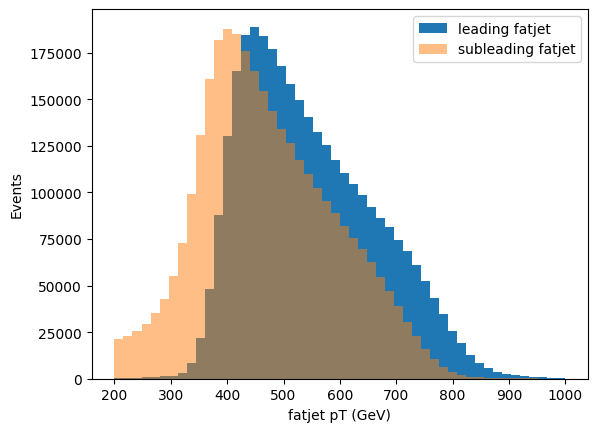

In [9]:
pT_leading_fatjet = events.fatJetPt[selection_2fatjet][:,0].compute()
pT_subleading_fatjet = events.fatJetPt[selection_2fatjet][:,1].compute()
print('The range of leading fatjet pT is from %.1f to %.1f GeV'%(ak.min(pT_leading_fatjet),ak.max(pT_leading_fatjet)))
print('The range of subleading fatjet pT is from %.1f to %.1f GeV'%(ak.min(pT_subleading_fatjet),ak.max(pT_subleading_fatjet)))

plt.hist(pT_leading_fatjet, bins=50, range=(200, 1000), label='leading fatjet')
plt.hist(pT_subleading_fatjet, bins=50, range=(200, 1000), alpha=.5, label='subleading fatjet')
plt.xlabel(r"fatjet pT (GeV)")
plt.ylabel("Events")
plt.legend()

The range of leading fatjet mass is from -0.0 to 866.3 GeV
The range of subleading fatjet mass is from -0.0 to 683.3 GeV


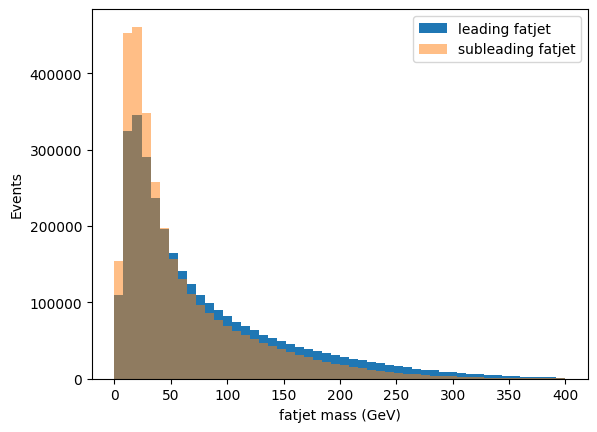

In [10]:
mass_leading_fatjet = events.fatJetM[selection_2fatjet][:,0].compute()
mass_subleading_fatjet = events.fatJetM[selection_2fatjet][:,1].compute()
print('The range of leading fatjet mass is from %.1f to %.1f GeV'%(ak.min(mass_leading_fatjet),ak.max(mass_leading_fatjet)))
print('The range of subleading fatjet mass is from %.1f to %.1f GeV'%(ak.min(mass_subleading_fatjet),ak.max(mass_subleading_fatjet)))

plt.hist(mass_leading_fatjet, bins=50, range=(0, 400), label='leading fatjet')
plt.hist(mass_subleading_fatjet, bins=50, range=(0, 400), alpha=.5, label='subleading fatjet')
plt.xlabel(r"fatjet mass (GeV)")
plt.ylabel("Events")
plt.legend()

## Use vrjets to do the flavor tagging

### Understanding the meanings of vrjets's labels

**What is vrjets?**

`vrjets` are those have small cone size inside one fatjet.

`vrJetIdFatJet` means which vrjets belong to which fatjet. Those vrjets labeled with 0 means they are in leading fatjet.

In [11]:
vrjet = events.vrJetIdFatJet.compute()
vrjet[ak.num(vrjet[vrjet==6])>0]
vrjet

<Array [[0, 0, 1, 1], ..., [0, 0, ..., 1, 1]] type='4078050 * [var * int32[...'>

In [12]:
vrjetpt = events.vrJetPt.compute()
vrjetpt[ak.num(vrjet[vrjet==6])>0]
vrjetpt

<Array [[6.65, 375, 12.1, 314], ..., [...]] type='4078050 * [var * float32[...'>

`vrJetHadronGhostTruthLabelID` is to classify quark's flavor of each vrjet, which is equivalent to flavor tagging. Note, this is truth-level information, only valid in MC simulation
- `vrJetHadronGhostTruthLabelID=0`, means light quark (u, d, s)
- `vrJetHadronGhostTruthLabelID=4`, means c quark
- `vrJetHadronGhostTruthLabelID=5`, means b quark

In [51]:
events.vrJetHadronGhostTruthLabelID.compute()

<Array [[0, 0, 0, 0], ..., [0, 0, ..., 0, 0]] type='4078050 * [var * int32[...'>

### Selection rules
Since we only care about vrjets inside the leading fatjet, so only those vrjets label with 0 will be used.
`vrJetIdFatJet==0` & `vrJetPt>20`

In [13]:
# still contains zero fatjet events
'''Why does the following doesn't work

#selection_vrjet_id_0 = (vrjetid==0) & (ak.num(vrjetid)>0)
'''
vrjet = events.vrJetIdFatJet.compute()
vrjetid = events.vrJetHadronGhostTruthLabelID.compute()
vrjetpt = events.vrJetPt.compute()
vrjet_cut = (vrjet==0) & (vrjetpt>20)
# Apply the cut to the original vrjet arrays
print('the event number with vrjet cut is %i, %.2f%%'%(len(vrjetid), len(vrjetid[vrjet_cut])/len(vrjetid)*100))
vrjetpt = vrjetpt[vrjet_cut]
vrjet = vrjet[vrjet_cut]
vrjetid = vrjetid[vrjet_cut]
#ak.min(ak.num(vrjet[vrjet_cut]))

the event number with vrjet cut is 4078050, 100.00%


Now we filter the vrjets only in the leading fatjet. With `vrJetHadronGhostTruthLabelID`, we can get the info about how many l, c, b quarks are there in the leading fatjet. 

We'll use the number of l, c, b quarks to tag leading fatjet.
- if Nb=2, tag fatjet as bb jets (reason why we don't add limit to Nc and Nq here is that those quarks can come from gluon splitting)
- if Nc=2, tag fatjet as cc jets
- if Nb=1 & Nq>0, tagging bq
- if Nc=1 & Nq>0, tagging cq
- if Nb=0 & Nc=0 & Nq>1, tagging qq (Nq>1 is to make sure Nfatjet>0)


In [34]:
bb_tagging = ak.num(vrjet[vrjetid == 5])==2
cc_tagging = ak.num(vrjet[vrjetid == 4])==2
bq_tagging = (ak.num(vrjet[vrjetid == 5])==1) & (ak.num(vrjet[vrjetid == 0])>0)
cq_tagging = (ak.num(vrjet[vrjetid == 4])==1) & (ak.num(vrjet[vrjetid == 0])>0)
qq_tagging = (ak.num(vrjet[vrjetid == 5])==0) & (ak.num(vrjet[vrjetid == 4])==0) & (ak.num(vrjet[vrjetid == 0])>1)

flavor_tagging = [bb_tagging, cc_tagging, bq_tagging, cq_tagging, qq_tagging]
N_tagging = [len(vrjetid[tag]) for tag in flavor_tagging]
N_tot = sum(N_tagging) # sum of all the tagging jets
fatjet_name = ['bb', 'cc', 'bq', 'cq', 'qq']
for tag, name in zip(flavor_tagging, fatjet_name):
    print(name, len(vrjetid[tag]), '%.2f%%'%(len(vrjetid[tag])/N_tot*100))
print('tot', N_tot)

bb 39617 1.61%
cc 72261 2.94%
bq 90178 3.68%
cq 232446 9.47%
qq 2019201 82.29%
tot 2453703


#### Questions:
1. Why do we choose selection rules of `vrjetPt>20GeV`? Is it related to trigger?
2. How do we know this classification is correct?
3. Why do we only care about the number of b quarks? Like why don't we add condition of Nb=2 & Nc=0 to tag bb jets? Could a fatjet be tagged as bb and cc at the same time if it contains Nb=2 and Nc=2? If that's the case, one single event will be tagged twice.
4. Do we require the number of vrjets has to be 2 in the leading fatjet? Or it could be more?
5. How to decide the order of selection?

##### 2. How do we know this classification is correct?
This is one of the classifications. We can also get the number of BHadrons `fatJetNBHadrons` with the `fatJetGN2XHbb` tagging. By comparing these two, we can figure out the difference between them.

In [109]:
fatjet_nb = events.fatJetNBHadrons.compute()
fatjet_nb_compare = fatjet_nb[bb_tagging][:,0]
print('tot ', len(fatjet_nb_compare))
for i in range(6):
    print('%i b jets # of events is %i'%(i, len(fatjet_nb_compare[fatjet_nb_compare==i])))

tot  39617
0 b jets # of events is 65
1 b jets # of events is 1729
2 b jets # of events is 36548
3 b jets # of events is 856
4 b jets # of events is 415
5 b jets # of events is 3


##### 3. Why do we only care about the number of b quarks? Like why don't we add condition of Nb=2 & Nc=0 to tag bb jets? Could a fatjet be tagged as bb and cc at the same time if it contains Nb=2 and Nc=2? If that's the case, one single event will be tagged twice.

In [39]:
bbcc_tagging = (ak.num(vrjet[vrjetid == 5])==2) & (ak.num(vrjet[vrjetid == 4])==2)
print('the number of events that contains Nb=2 and Nc=2 at the same time is', len(vrjetid[bbcc_tagging]), ', the fraction is %.5f%%'%(len(vrjetid[bbcc_tagging])/N_tot*100))

the number of events that contains Nb=2 and Nc=2 at the same time is 95 , the fraction is 0.00387%


[[0, 5, 5], [5, 5, 0], [0, 5, 5]]
[[145, 81, 70.6], [25.3, 38.6, 249], [70, 88.4, 80]]
absolute values of the pT difference between two b jets in the bb fatjet
 [37.4, 196, 146, 10.5, 13.3, 8.42, 25.1, ..., 105, 131, 291, 206, 173, 124, 162]


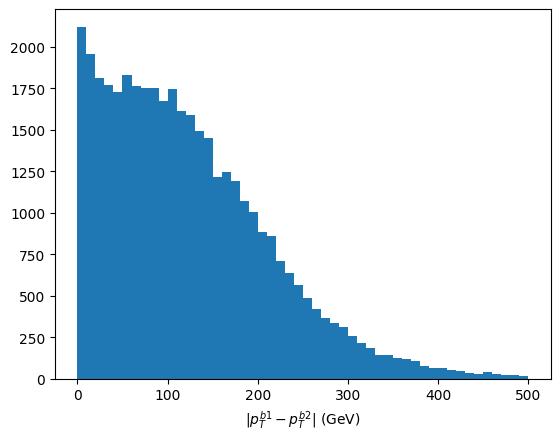

In [72]:
bb_id = vrjetid[bb_tagging]
bb_pt = vrjetpt[bb_tagging]
print(bb_id[3:6])
print(bb_pt[3:6])
bb_pt = bb_pt[bb_id==5]
print('absolute values of the pT difference between two b jets in the bb fatjet\n', abs(bb_pt[:,0]-bb_pt[:,1]))
plt.hist(abs(bb_pt[:,0]-bb_pt[:,1]), bins=50, range=(0,500))
plt.xlabel(r'$|p_T^{b1}-p_T^{b2}|$ (GeV)')
plt.show()

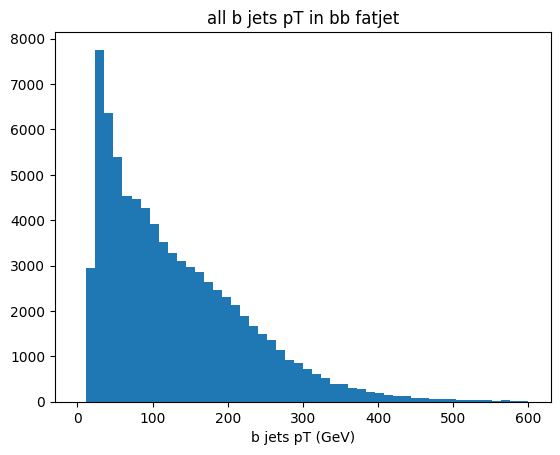

In [67]:
plt.hist(ak.flatten(bb_pt), bins=50, range=(0, 600))
plt.xlabel('b jets pT (GeV)')
plt.title('all b jets pT in bb fatjet')
plt.show()

### Look into different variables (mass+pT)

#### mass for different jets

In [99]:
'''
return histogram distribution for a certain kinematics
input: kinematic is events.sth; 
'''
def generate_histo(kinematic, bins, kinematic_name, fatjet_name, flavor_tagging):
    # Generate two total lists to contain different jets histogram
    N_bin_flavor_unweighted = []
    N_bin_flavor_weighted = []
    
    for tag, name in zip(flavor_tagging[:], fatjet_name[:]): 
        N_bin_flavor_unweighted.append(np.histogram(kinematic[tag][:,0].compute(), bins=bins)[0]) # [:,0] is only for the leading fatjet
        N_bin_flavor_weighted.append(np.histogram(kinematic[tag][:,0].compute(), bins=bins, weights=events.eventMCWeight[tag].compute())[0])    
        print('The range of %s %s is from %.1f to %.1f GeV'%(name, kinematic_name, ak.min(kinematic[tag][:,0].compute()),ak.max(kinematic[tag][:,0].compute())))

    return N_bin_flavor_unweighted, N_bin_flavor_weighted

In [100]:
dx = 5
bins = np.arange(0,600,dx)
mass_unweighted, mass_weighted = generate_histo(events.fatJetM, bins, 'mass', fatjet_name, flavor_tagging)

The range of bb mass is from 1.1 to 828.9 GeV
The range of cc mass is from 1.7 to 922.5 GeV
The range of bq mass is from 0.7 to 682.6 GeV
The range of cq mass is from 0.5 to 866.3 GeV
The range of qq mass is from -0.0 to 802.1 GeV


In [85]:
def events_num_plot(N_bin_flavor, edges, xlabel, title, x_range, y_range, fatjet_name, log):
    for jets, name in zip(N_bin_flavor, fatjet_name):
        plt.stairs(jets, bins, label=name)
    plt.xlabel(xlabel)
    plt.ylabel("Events")
    if log == True:
        plt.yscale('log')
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.title('number of events '+title)
    plt.legend()

/tmp/ipykernel_7616/3297452912.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(y_range)


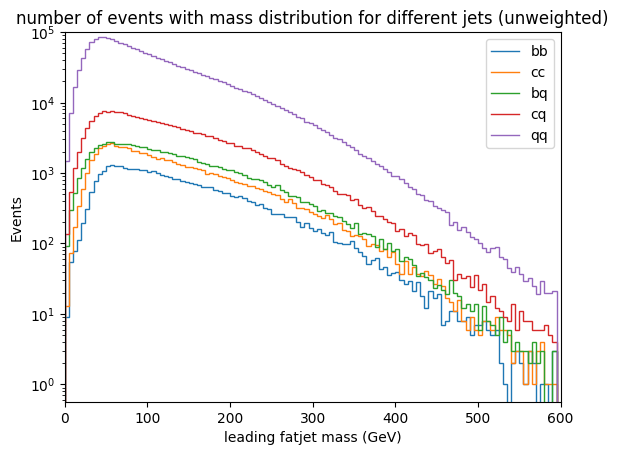

In [86]:
title='with mass distribution for different jets (unweighted)'
xlabel='leading fatjet mass (GeV)'
x_range=(0,600)
y_range=(0, 1e5)
events_num_plot(mass_unweighted, bins, xlabel, title, x_range, y_range, fatjet_name, True)

In [91]:
def fraction_plot(N_bin_flavor, edges, xlabel, title, x_range, y_range, fatjet_name, log):
    N_bin_flavor = np.array(N_bin_flavor)
    N_tot=np.sum(N_bin_flavor, axis=0)
    for i in range(len(N_bin_flavor)):
        plt.stairs(N_bin_flavor[i]/N_tot, edges, label=fatjet_name[i])
    plt.legend()
    if log == True:
        plt.yscale('log')
    plt.ylim(y_range)
    plt.xlim(x_range)
    plt.title('fraction '+title)

/tmp/ipykernel_7616/926228306.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(y_range)


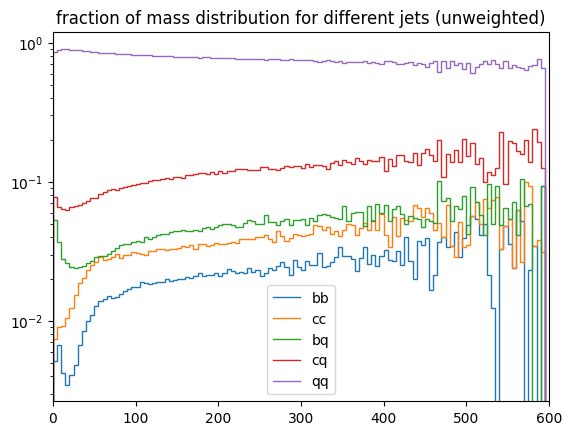

In [93]:
title='of mass distribution for different jets (unweighted)'
xlabel='leading fatjet mass (GeV)'
x_range=(0,600)
y_range=(0, 1.2)
fraction_plot(mass_unweighted, bins, xlabel, title, x_range, y_range, fatjet_name, True)

5


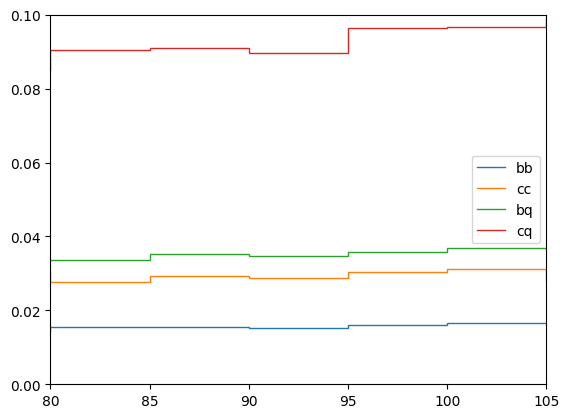

In [240]:
fraction_plot(N_bin_flavor_weighted, bins, (80,105), (0,.1), fatjet_name)

#### pT for different jets

In [101]:
bins = np.linspace(200,1000,100)
pT_unweighted, pT_weighted = generate_histo(events.fatJetPt, bins, 'pT',  fatjet_name, flavor_tagging)

The range of bb pT is from 201.4 to 1419.5 GeV
The range of cc pT is from 200.7 to 1554.5 GeV
The range of bq pT is from 201.5 to 1454.6 GeV
The range of cq pT is from 200.7 to 1466.2 GeV
The range of qq pT is from 200.2 to 1520.8 GeV


/tmp/ipykernel_7616/3297452912.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(y_range)


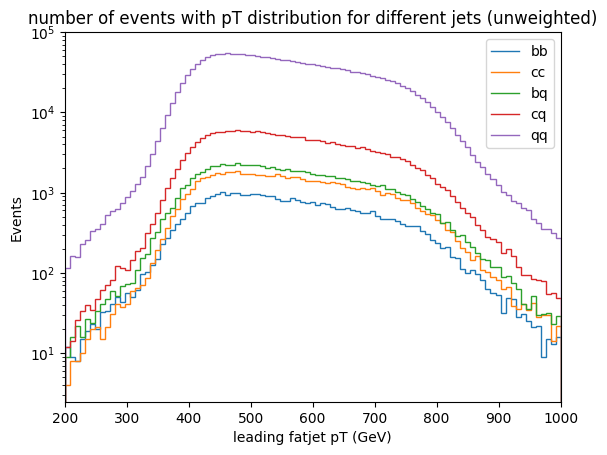

In [105]:
title='with pT distribution for different jets (unweighted)'
xlabel='leading fatjet pT (GeV)'
x_range=(200,1000)
y_range=(0, 1e5)
events_num_plot(pT_unweighted, bins, xlabel, title, x_range, y_range, fatjet_name, True)

/tmp/ipykernel_7616/926228306.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(y_range)


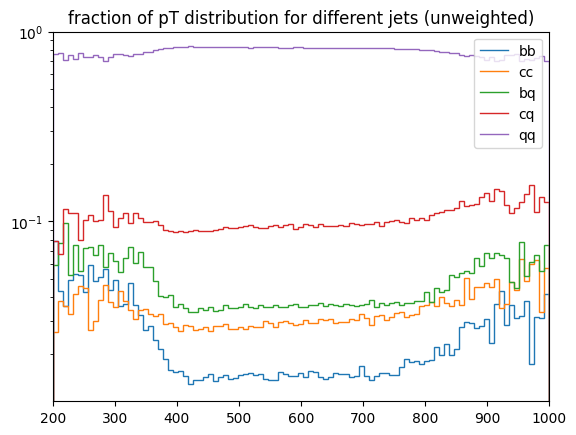

In [107]:
title='of pT distribution for different jets (unweighted)'
y_range=(0, 1)
fraction_plot(pT_unweighted, bins, xlabel, title, x_range, y_range, fatjet_name, True)

The range of bb pT is from 201.1 to 1440.9 GeV
The range of cc pT is from 200.7 to 1554.5 GeV


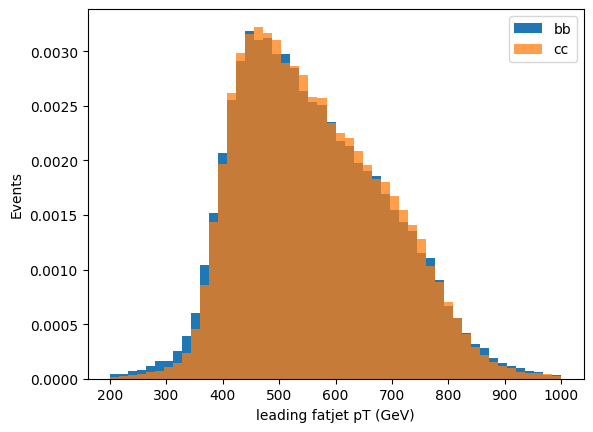

In [88]:
alpha = [1, .75, .5, .25, .1]
for tag, name, alpha_value in zip(flavor_tagging[:2], fatjet_name[:2], alpha[:2]): 
    plt.hist(events.fatJetPt[tag][:,0].compute(), alpha=alpha_value, bins=50, range=(200, 1000), label=name, density=True)
    print('The range of %s pT is from %.1f to %.1f GeV'%(name, ak.min(events.fatJetPt[tag][:,0].compute()),ak.max(events.fatJetPt[tag][:,0].compute())))
plt.xlabel(r"leading fatjet pT (GeV)")
plt.ylabel("Events")
#plt.yscale('log')
plt.legend()

### Fitting

# General Questions
1. How to calculate fatjet pT? Is there any relationship between vrjets pT and fatjet pT?
2. Where to get the 4 momentum info? How do convert from (px, py, pz, E) to (phi, eta, pT, m)? Where do those fat jets come from (trigger system?) what's the delta R distribution?
3. How to sort awkward array in a more efficient way? vrjetpT are not sorted. How to build a sorted array?
4. How to use dash to accelerate coffea? Are they equivalent to using CPU cores? If that's the case, should I use dash at all if I can apply enough CPU for jupyter notebook? How many CPU I can apply at most?
5. How to make sure that leading fatjet do come from Higgs? Why do we only care about leading fatjet?

In [ ]:
dr = events[selection_2fatjet][:, 0].delta_r(events[selection_2fatjet][:, 1])

In [20]:
vrjet_id_0 = vrjet==0
vrjet_id_1 = vrjet==1
# pick vrjet whose id is 0
vrjetpt_id_0 = vrjetpt[vrjet_id_0]
vrjetpt_id_0= vrjetpt_id_0[ak.num(vrjetpt_id_0)>1]
print(len(vrjetpt_id_0))
# check whether it has been sorted or not
vrjetpt_id_0[(vrjetpt_id_0[:,-1] - vrjetpt_id_0[:,-2])>0]
#print(len(vrjetpt_id_0[(vrjetpt_id_0[:,-1] - vrjetpt_id_0[:,-2])>0]))
#vrjetpt_id_1 = vrjetpt[vrjet_id_1]

3650515


<Array [[9.52, 322, 90.3], ..., [7.56, ...]] type='221657 * var * float32[p...'>